In [39]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [40]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


TensorFlow version: 2.16.1
Num GPUs Available:  0


In [41]:
import tensorflow as tf

# Example GPU operation
with tf.device('/GPU:0'):
    matrix1 = tf.constant([[1., 2.], [3., 4.]])
    matrix2 = tf.constant([[5., 6.], [7., 8.]])
    result = tf.matmul(matrix1, matrix2)

print(result)


tf.Tensor(
[[19. 22.]
 [43. 50.]], shape=(2, 2), dtype=float32)


In [42]:
import torch
print("GPU available:", torch.cuda.is_available())


GPU available: True


HERE IS CLASSIC DATA

In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")
else:
    print(f"GPU runtime succesfully selected! We're ready to train our CNNs.")

# Common imports
import numpy as np
import os
import pooch

# to make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Loading Tensorboard
# Let's clear out the backend and set our random seeds
# Consistency makes things easier for labs!
keras.backend.clear_session()
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)

#FOR CLASSIC DATA WITHOUT ORDERING
from PIL import Image
import tensorflow as tf
import os
import random
import shutil
from pathlib import Path
import pandas as pd

# Define paths
base_dir = Path(r'C:\Users\bapti\Downloads\ML_Project\Copy_full_fish_dataset')
#base_dir = Path(r'C:\Users\bapti\Downloads\Mask_creation')
output_dir = Path(r'C:\Users\bapti\Downloads\ML_Project\Data_ready')
#output_dir = Path(r'C:\Users\bapti\Downloads\Mask_data_ready')

#For Ubuntu: 
base_dir = Path('/mnt/c/Users/bapti/Downloads/ML_Project/Copy_full_fish_dataset')
output_dir = Path('/mnt/c/Users/bapti/Downloads/ML_Project/Data_ready')

train_dir = output_dir / 'Train'
valid_dir = output_dir / 'Valid'
test_dir = output_dir / 'Test'

# Ensure output directories exist
for path in [train_dir, valid_dir, test_dir]:
    path.mkdir(parents=True, exist_ok=True)

# Collect all images with metadata
data = []
test_data = []

for class_name in ["LEFT", "RIGHT"]:
    class_dir = base_dir / class_name
    for species_name in ["Grayling", "Trout"]:
        species_dir = class_dir / species_name
        for date_folder in species_dir.iterdir():
            if date_folder.is_dir():
                date = date_folder.name
                for image_file in date_folder.glob('*.*'):
                    # Store metadata with each image path
                    item = {
                        "path": image_file,
                        "class": class_name,
                        "species": species_name,
                        "date": date
                    }
                    # Assign test data based on specified conditions
                    if (species_name == "Grayling" and date == "Day_35") or \
                       (species_name == "Trout" and date == "Day_146"):
                        test_data.append(item)
                    else:
                        data.append(item)

# # Shuffle data for random splitting
# random.seed(123)  # For reproducibility
# random.shuffle(data)

# # Split remaining data into train (85%) and validation (15%)
# total_count = len(data)
# train_count = int(0.85 * total_count)

# train_data = data[:train_count]
# valid_data = data[train_count:]



No GPU was detected. CNNs can be very slow without a GPU.


In [44]:
# Load the datasets from the new directories
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),  # Specify your desired image size
    batch_size=32,          # Specify your desired batch size
    seed=123,
)

valid_set = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    image_size=(256, 256),
    batch_size=32,
    seed=123,
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    seed=123,
)

train_set.name = 'Training'
valid_set.name = 'Validation'
test_set.name = 'Test'

# Print class names and dataset sizes
class_names = train_set.class_names
print("Class names:", class_names)
print("Training dataset size:", len(train_set))
print("Validation dataset size:", len(valid_set))
print("Test dataset size:", len(test_set))

# Print number of test images
print("\n","Total number of images in the input dataset:", "\n","train + valid:",len(data), "\n","test:",len(test_data))


Found 4950 files belonging to 2 classes.
Found 874 files belonging to 2 classes.
Found 843 files belonging to 2 classes.
Class names: ['LEFT', 'RIGHT']
Training dataset size: 155
Validation dataset size: 28
Test dataset size: 27

 Total number of images in the input dataset: 
 train + valid: 6028 
 test: 843


In [45]:
#PREPROCESSING FOR THE BASELINE MODELS:
def preprocessing_function(image, label):
    # We're going to hard code the image size we want to use. We can define this
    # with a lambda function, but we won't really need to change this and it's
    # more trouble than it's worth for us right now :)
    # image_size = 128
    num_classes = 2

    # Cast the image and label datatypes
    image = tf.cast(image, tf.float32)
    label = tf.cast(label,tf.int32)

    # Normalize the pixel values. Use a float value in the denominator!
    image = image / 255.0

    # Resize the image
    # image = tf.image.resize(image, ( image_size,  image_size))

    # Cast the label to int32 and one-hot encode
    label = tf.one_hot(label, num_classes)
    # Recast label to Float32
    label = tf.cast(label, tf.float32)

    return image, label

train = train_set.map(preprocessing_function)
valid = valid_set.map(preprocessing_function)
test = test_set.map(preprocessing_function)


In [46]:
train = train
validation = valid
test = test


def get_CNN_logdir():
    time = np.datetime64('now').astype(str)[:-3].replace(':', '-')
    run_logdir = os.path.join(os.curdir, "Final_CNN_logs", f"Baseline_run_on_classic_data{time}") # time goes in the fstring
    return run_logdir


early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Baseline_run_on_classic_data.keras",
                                                   save_best_only=True,
                                                   monitor='val_loss')
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_CNN_logdir())

# Let's clear out the backend and set our random seeds.
# Consistency is key :)
keras.backend.clear_session()
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)


In [47]:
model = keras.models.Sequential([
    # Convolution 1
    keras.layers.Conv2D(filters=32, kernel_size=7, padding="same", activation="relu"),
    keras.layers.MaxPool2D((3,3)),

    # Convolution 2
    keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),


    # Convolution 3
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),


    # Convolution 4
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),


    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation="softmax") #Change the last layer from 5 classes to 2 classes
])

In [48]:
model.build((None, 256 , 256, 3))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [49]:
import datetime
import tensorflow as tf

# Adjust timestamp to avoid colons
timestamp = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
log_dir = f".\\Final_CNN_logs\\Baseline_run_on_classic_data{timestamp}"

#For Ubuntu 
log_dir = Path(f"Final_CNN_logs/Baseline_run_on_classic_data{timestamp}")
log_dir_str = log_dir.as_posix()

# Define TensorBoard callback with corrected log directory path
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Now run the model training
history = model.fit(train, # Training data generator
                    epochs=30,
                    validation_data=validation, # Validation data generator
                    callbacks=[early_stopping_cb,
                               checkpoint_cb,
                               tensorboard_cb])

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.5175 - loss: 0.7759 - val_accuracy: 0.5206 - val_loss: 0.6923
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 108s 692ms/step - accuracy: 0.5151 - loss: 0.6931 - val_accuracy: 0.5206 - val_loss: 0.6923
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 108s 692ms/step - accuracy: 0.5150 - loss: 0.6932 - val_accuracy: 0.5206 - val_loss: 0.6923
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 107s 690ms/step - accuracy: 0.5173 - loss: 0.6927 - val_accuracy: 0.5206 - val_loss: 0.6924
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 107s 689ms/step - accuracy: 0.5163 - loss: 0.6928 - val_accuracy: 0.5206 - val_loss: 0.6924
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 107s 689ms/step - accuracy: 0.5155 - loss: 0.6933 - val_accuracy: 0.5206 - val_loss: 0.6923
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 107s 690ms/step - accuracy: 0.5178 - loss: 0.6927 - val_accuracy: 0.5206 - val_loss: 0.6923
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 107s 685ms/step - accuracy: 0.5137 - lo

FOLLOWING IS FOR BASELINE WITH DATA AUGMENTATION

In [50]:
keras.backend.clear_session()
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)

In [51]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Augmented_run_on_classic_data.keras",
                                                   save_best_only=True,
                                                   monitor='val_loss')
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_CNN_logdir())

In [52]:
aug_model = keras.models.Sequential([
    #keras.layers.RandomFlip(), # Flip augmentation removed 
    keras.layers.RandomRotation(0.08), # Rotation Aumentation
    #keras.layers.RandomBrightness([0.2,1.0]),
    keras.layers.RandomContrast(0.9),
    keras.layers.RandomTranslation(-0.08,0.08),
    keras.layers.GaussianNoise( 0.1 , seed =42),
    # Convolution 1
    keras.layers.Conv2D(filters=32, kernel_size=7, padding="same", activation="relu"),
    keras.layers.MaxPool2D((3,3)),

    # Convolution 2
    keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),


    # Convolution 3
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),


    # Convolution 4
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),


    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation="softmax") #Change the last layer from 5 classes to 2 classes

    # Copy your previous model's layers here
])
aug_model.build((None, 256 , 256, 3))

In [53]:
import tensorflow
from tensorflow.keras.optimizers import Adam


# Set a custom learning rate
learning_rate = 0.001  # Try different values: 0.0001, 0.001, 0.005, etc.
optimizer = Adam(learning_rate=learning_rate)

#changed optimizer = "adam" to this:
aug_model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

In [54]:


import datetime

# Generate a valid directory path
log_dir = f".\\Final_CNN_logs\\Augmented_run_on_classic_data{datetime.datetime.now().strftime('%Y-%m-%dT%H-%M-%S')}"
#For Ubuntu
log_dir = Path(f"Final_CNN_logs/Augmented_run_on_classic_data{datetime.datetime.now().strftime('%Y-%m-%dT%H-%M-%S')}")
log_dir_str = log_dir.as_posix()
#
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)



# Can remove here because made error before with Data augment. model
# # Assuming your model currently ends with layers suitable for image output
# # Add a Flatten layer to convert the multi-dimensional output to a 1D vector
# model.add(tf.keras.layers.Flatten())

# # Add a Dense layer with 5 units (for 5 classes) and softmax activation --> 2 units
# # for categorical classification 
# model.add(tf.keras.layers.Dense(2, activation='softmax'))

# # Recompile the model with the updated architecture
# model.compile(loss="categorical_crossentropy",
#               optimizer='adam',
#               metrics=['accuracy'])

history = aug_model.fit(train, # Training data generator
                    epochs=30,
                    validation_data=validation, # Validation data generator
                    callbacks=[early_stopping_cb,
                               checkpoint_cb,
                               tensorboard_cb])

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.4854 - loss: 1.0592 - val_accuracy: 0.5206 - val_loss: 0.6924
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 112s 718ms/step - accuracy: 0.5167 - loss: 0.6929 - val_accuracy: 0.5206 - val_loss: 0.6924
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 126s 813ms/step - accuracy: 0.5137 - loss: 0.6930 - val_accuracy: 0.5206 - val_loss: 0.6924
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 123s 792ms/step - accuracy: 0.5160 - loss: 0.6928 - val_accuracy: 0.5206 - val_loss: 0.6923
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 126s 809ms/step - accuracy: 0.5136 - loss: 0.6928 - val_accuracy: 0.5206 - val_loss: 0.6923
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 112s 721ms/step - accuracy: 0.5137 - loss: 0.6929 - val_accuracy: 0.5206 - val_loss: 0.6924
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 113s 723ms/step - accuracy: 0.5187 - loss: 0.6929 - val_accuracy: 0.5206 - val_loss: 0.6924
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 113s 724ms/step - accuracy: 0.5153 - lo

In [55]:
import os
print(os.listdir())

current_directory = os.getcwd()
print(current_directory)
model.save('Baseline_run_on_classic_data.h5')
aug_model.save('Augmented_run_on_classic_data.h5')

# Let's load the models!
non_aug_model = keras.models.load_model(r'Baseline_run_on_classic_data.h5')
aug_model = keras.models.load_model(r'Augmented_run_on_classic_data.h5')

# And test them on the testing dataset
non_aug_model.evaluate(test)
aug_model.evaluate(test)

['50_epoch_models', 'Augmented_run_on_classic_data.h5', 'Augmented_run_on_classic_data.keras', 'Augmented_run_on_mask_data.h5', 'Baseline_run_on_classic_data.h5', 'Baseline_run_on_classic_data.keras', 'Baseline_run_on_mask_data.h5', 'CNN_logs', 'CNN_ResNet_classic_data.h5', 'CNN_ResNet_mask_data.h5', 'Copy_full_fish_dataset', 'Data_ready', 'Final_CNN_logs', 'images', 'Mask_data_ready', 'mp4_to_mp3.py', 'Obsolete_Data_to_be_hand_classified', 'Obsolete_DAY0_fish_dataset', 'Obsolete_Fish_Mask_Output', 'ResNet.ipynb', 'S5_1_CNNs_Brown_trout_data.ipynb', 'Segment_Anything_SAM.py', 'test_ZF_Net.py']
/mnt/c/Users/bapti/Downloads/ML_Project


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.4846 - loss: 0.6947
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.4776 - loss: 0.6951


[0.6942036747932434, 0.4911032021045685]

In [56]:
#PREPROCESSING FOR THE RESNET:

def preprocessing_function(image, label):
    # We're going to hard code the image size we want to use. We can define this
    # with a lambda function, but we won't really need to change this and it's
    # more trouble than it's worth for us right now :)
    # image_size = 128
    num_classes = 2

    # Cast the image and label datatypes
    image = tf.cast(image, tf.float32)
    label = tf.cast(label,tf.int32)

    # Resize the image to (224, 224) for ResNet50
    image = tf.image.resize(image, (224, 224))
    
    # Normalize the pixel values. Use a float value in the denominator!
    image = image / 255.0

    # Resize the image
    # image = tf.image.resize(image, ( image_size,  image_size))

    # Cast the label to int32 and one-hot encode
    label = tf.one_hot(label, num_classes)
    # Recast label to Float32
    label = tf.cast(label, tf.float32)

    return image, label

train = train_set.map(preprocessing_function)
valid = valid_set.map(preprocessing_function)
test = test_set.map(preprocessing_function)

In [57]:

for images, labels in train.take(1):
  print(f'Images shape: {images.numpy().shape} Labels: {labels.numpy().shape}')

Images shape: (32, 224, 224, 3) Labels: (32, 2)


2024-11-30 19:06:30.056657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [58]:
###CNN_RESNET_ON_CLASSIC_DATA ALREADY SAVED

train = train
validation = valid
test = test


def get_CNN_logdir():
    time = np.datetime64('now').astype(str)[:-3].replace(':', '-')
    run_logdir = os.path.join(os.curdir, "Final_CNN_logs", f"ResNet_run_on_classic_data{time}") # time goes in the fstring
    return run_logdir


early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("CNN_ResNet_classic_data.keras",
                                                   save_best_only=True,
                                                   monitor='val_loss')
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_CNN_logdir())

# Let's clear out the backend and set our random seeds.
# Consistency is key :)
keras.backend.clear_session()
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)

n_classes = 2

# Load ResNet50 with no top layers (without classification layers)
base_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

# Freeze the base model
for layer in base_model.layers[-10:]:
    layer.trainable = False
# base_model.trainable = False

#inputs = train.map(lambda image, label: (keras.applications.resnet50.preprocess_input(image * 255), label))

inputs = train.map(lambda image, label: (image, label))


optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.01) 
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]) 

import datetime

# Generate a valid directory path

log_dir = f".\\Final_CNN_logs\\ResNet_run_on_classic_data{datetime.datetime.now().strftime('%Y-%m-%dT%H-%M-%S')}"

#For Ubuntu
log_dir = Path(f"Final_CNN_logs/ResNet_run_on_classic_data{datetime.datetime.now().strftime('%Y-%m-%dT%H-%M-%S')}")
log_dir_str = log_dir.as_posix()

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
history = model.fit(train, epochs=30, validation_data=valid, callbacks=[early_stopping_cb,checkpoint_cb,tensorboard_cb])



Epoch 1/30


/home/baptiste07/miniconda3/envs/GPU/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


155/155 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.8292 - loss: 0.3311 - val_accuracy: 0.5206 - val_loss: 0.6938
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.9963 - loss: 0.0089 - val_accuracy: 0.4794 - val_loss: 0.9048
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 1.0000 - loss: 7.8464e-04 - val_accuracy: 0.4794 - val_loss: 0.7813
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 1.0000 - loss: 4.6556e-05 - val_accuracy: 0.4805 - val_loss: 0.7347
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 1.0000 - loss: 3.6792e-05 - val_accuracy: 0.8432 - val_loss: 0.2778
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 1.0000 - loss: 2.0947e-05 - val_accuracy: 0.9989 - val_loss: 0.0074
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 1.0000 - loss: 1.9437e-05 - val_accuracy: 1.0000 - val_loss: 5.4983e-04
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 1.0000 - loss: 2.45

In [59]:
model.save('CNN_ResNet_classic_data.h5')

In [7]:
#CHANGE DATA TO MASK DATA

#FOR CLASSIC DATA WITHOUT ORDERING
from PIL import Image
import tensorflow as tf
import os
import random
import shutil
from pathlib import Path
import pandas as pd

# Define paths
#base_dir = Path(r'C:\Users\bapti\Downloads\ML_Project\Copy_full_fish_dataset')
base_dir = Path(r'C:\Users\bapti\Downloads\Mask_creation')
#output_dir = Path(r'C:\Users\bapti\Downloads\ML_Project\Data_ready')
output_dir = Path(r'C:\Users\bapti\Downloads\Mask_data_ready')
#For Ubuntu: 
base_dir = Path('/mnt/c/Users/bapti/Downloads/Mask_creation')
output_dir = Path('/mnt/c/Users/bapti/Downloads/Mask_data_ready')

train_dir = output_dir / 'Train'
valid_dir = output_dir / 'Valid'
test_dir = output_dir / 'Test'

# Ensure output directories exist
for path in [train_dir, valid_dir, test_dir]:
    path.mkdir(parents=True, exist_ok=True)

# Collect all images with metadata
data = []
test_data = []

for class_name in ["LEFT", "RIGHT"]:
    class_dir = base_dir / class_name
    for species_name in ["Grayling", "Trout"]:
        species_dir = class_dir / species_name
        for date_folder in species_dir.iterdir():
            if date_folder.is_dir():
                date = date_folder.name
                for image_file in date_folder.glob('*.*'):
                    # Store metadata with each image path
                    item = {
                        "path": image_file,
                        "class": class_name,
                        "species": species_name,
                        "date": date
                    }
                    # Assign test data based on specified conditions
                    if (species_name == "Grayling" and date == "Day_35") or \
                       (species_name == "Trout" and date == "Day_146"):
                        test_data.append(item)
                    else:
                        data.append(item)

# Shuffle data for random splitting
random.seed(123)  # For reproducibility
random.shuffle(data)

# Split remaining data into train (85%) and validation (15%)
total_count = len(data)
train_count = int(0.85 * total_count)

train_data = data[:train_count]
valid_data = data[train_count:]

# Load the datasets from the new directories
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),  # Specify your desired image size
    batch_size=32,          # Specify your desired batch size
    seed=123,
)

valid_set = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    image_size=(256, 256),
    batch_size=32,
    seed=123,
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    seed=123,
)

train_set.name = 'Training'
valid_set.name = 'Validation'
test_set.name = 'Test'

# Print class names and dataset sizes
class_names = train_set.class_names
print("Class names:", class_names)
print("Training dataset size:", len(train_set))
print("Validation dataset size:", len(valid_set))
print("Test dataset size:", len(test_set))

# Print number of test images
print("\n","Total number of images in the input dataset:", "\n","train + valid:",len(data), "\n","test:",len(test_data))

#batch size set to 1 instead of 32 because of low data

def preprocessing_function(image, label):
    # We're going to hard code the image size we want to use. We can define this
    # with a lambda function, but we won't really need to change this and it's
    # more trouble than it's worth for us right now :)
    # image_size = 128
    num_classes = 2

    # Cast the image and label datatypes
    image = tf.cast(image, tf.float32)
    label = tf.cast(label,tf.int32)

    # Resize the image to (224, 224) for ResNet50
    image = tf.image.resize(image, (224, 224))
    
    # Normalize the pixel values. Use a float value in the denominator!
    image = image / 255.0

    # Resize the image
    # image = tf.image.resize(image, ( image_size,  image_size))

    # Cast the label to int32 and one-hot encode
    label = tf.one_hot(label, num_classes)
    # Recast label to Float32
    label = tf.cast(label, tf.float32)

    return image, label

train = train_set.map(preprocessing_function)
valid = valid_set.map(preprocessing_function)
test = test_set.map(preprocessing_function)

Found 4947 files belonging to 2 classes.
Found 874 files belonging to 2 classes.
Found 822 files belonging to 2 classes.
Class names: ['LEFT', 'RIGHT']
Training dataset size: 155
Validation dataset size: 28
Test dataset size: 26

 Total number of images in the input dataset: 
 train + valid: 5821 
 test: 822


In [ ]:
###CNN_RESNET_ON_MASK_DATA ALREADY SAVED

train = train
validation = valid
test = test


def get_CNN_logdir():
    time = np.datetime64('now').astype(str)[:-3].replace(':', '-')
    run_logdir = os.path.join(os.curdir, "Final_CNN_logs", f"ResNet_run_on_mask_data{time}") # time goes in the fstring
    return run_logdir


early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=40)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("CNN_ResNet_mask_data.keras",
                                                   save_best_only=True,
                                                   monitor='val_loss')
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_CNN_logdir())

# Let's clear out the backend and set our random seeds.
# Consistency is key :)
keras.backend.clear_session()
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)
print("HEY")

n_classes = 2

# Load ResNet50 with no top layers (without classification layers)
base_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

# Freeze the base model
for layer in base_model.layers[-10:]:
    layer.trainable = False
# base_model.trainable = False

#inputs = train.map(lambda image, label: (keras.applications.resnet50.preprocess_input(image * 255), label))

inputs = train.map(lambda image, label: (image, label))


optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.01) 
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]) 

import datetime

# Generate a valid directory path

log_dir = f".\\Final_CNN_logs\\ResNet_run_on_mask_data{datetime.datetime.now().strftime('%Y-%m-%dT%H-%M-%S')}"
#For Ubuntu
log_dir = Path(f"Final_CNN_logs/ResNet_run_on_mask_data{datetime.datetime.now().strftime('%Y-%m-%dT%H-%M-%S')}")
log_dir_str = log_dir.as_posix()
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
history = model.fit(train, epochs=30, validation_data=valid, callbacks=[early_stopping_cb,checkpoint_cb,tensorboard_cb])


HEY


In [62]:
model.save('CNN_ResNet_mask_data.h5')

In [63]:
# #Has not worked, plot the expected side of the fish:

# inputs = test.map(lambda image, label: (keras.applications.resnet50.preprocess_input(image * 255), label))
# # inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
# Y_proba = model.predict(inputs)

# # Display the probabilities for LEFT and RIGHT
# for image_index in range(min(25, len(Y_proba))):
#     print(f"Image #{image_index}")
    
#     plt.figure(figsize=(5, 5))
    
#     # Show the image (use images.numpy() to convert the tensor to a numpy array)
#     plt.imshow(images[image_index].numpy())  # Assuming 'images' is a batch of images
#     plt.axis('off')  # Hide axis
    
#     # Display the probabilities for LEFT and RIGHT
#     left_prob = Y_proba[image_index][0] * 100  # Probability for LEFT class
#     right_prob = Y_proba[image_index][1] * 100  # Probability for RIGHT class
#     plt.title(f"Image #{image_index}\nLEFT: {left_prob:.2f}% | RIGHT: {right_prob:.2f}%", fontsize=12)
    
#     # Show the image with the prediction
#     plt.show()


In [9]:
import os
print(os.listdir())

current_directory = os.getcwd()
print(current_directory)
# # model.save('CNN_ResNet.h5')
# #aug_model = keras.models.load_model('path/to/your/directory/CNN_augmented.h5')
# # Let's load the models!
######## ALREADY SAVED
# classic_model = keras.models.load_model(r'CNN_ResNet_classic_data.h5')
# mask_model = keras.models.load_model(r'CNN_ResNet_mask_data.h5')

# And test them on the testing dataset
# classic_model.evaluate(test)
# mask_model.evaluate(test)

['50_epoch_models', 'Augmented_run_on_classic_data.h5', 'Augmented_run_on_classic_data.keras', 'Augmented_run_on_mask_data.h5', 'Baseline_run_on_classic_data.h5', 'Baseline_run_on_classic_data.keras', 'Baseline_run_on_mask_data.h5', 'Baseline_run_on_mask_data.keras', 'CNN_logs', 'CNN_ResNet_classic_data.h5', 'CNN_ResNet_classic_data.keras', 'CNN_ResNet_mask_data.h5', 'CNN_ResNet_mask_data.keras', 'Copy_full_fish_dataset', 'Data_ready', 'Final_CNN_logs', 'images', 'Mask_data_ready', 'mp4_to_mp3.py', 'Obsolete_Data_to_be_hand_classified', 'Obsolete_DAY0_fish_dataset', 'Obsolete_Fish_Mask_Output', 'ResNet.ipynb', 'S5_1_CNNs_Brown_trout_data.ipynb', 'Segment_Anything_SAM.py', 'test_ZF_Net.py', 'tmp4zvhfqdx']
/mnt/c/Users/bapti/Downloads/ML_Project


In [ ]:
# # # TO SEE RESULTS:
# %tensorboard --logdir=./Final_CNN_logs --port=6006

: 

In [10]:
import numpy as np
# BASELINE RUN ON MASK DATA:
#
# 
 #PREPROCESSING FOR THE BASELINE MODELS:
def preprocessing_function(image, label):
    # We're going to hard code the image size we want to use. We can define this
    # with a lambda function, but we won't really need to change this and it's
    # more trouble than it's worth for us right now :)
    # image_size = 128
    num_classes = 2

    # Cast the image and label datatypes
    image = tf.cast(image, tf.float32)
    label = tf.cast(label,tf.int32)

    # Normalize the pixel values. Use a float value in the denominator!
    image = image / 255.0

    # Resize the image
    # image = tf.image.resize(image, ( image_size,  image_size))

    # Cast the label to int32 and one-hot encode
    label = tf.one_hot(label, num_classes)
    # Recast label to Float32
    label = tf.cast(label, tf.float32)

    return image, label

train = train_set.map(preprocessing_function)
valid = valid_set.map(preprocessing_function)
test = test_set.map(preprocessing_function)

train = train
validation = valid
test = test


def get_CNN_logdir():
    time = np.datetime64('now').astype(str)[:-3].replace(':', '-')
    run_logdir = os.path.join(os.curdir, "Final_CNN_logs", f"Baseline_run_on_mask_data{time}") # time goes in the fstring
    return run_logdir


early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=40)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Baseline_run_on_mask_data.keras",
                                                   save_best_only=True,
                                                   monitor='val_loss')
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_CNN_logdir())

# Let's clear out the backend and set our random seeds.
# Consistency is key :)
keras.backend.clear_session()
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)

model = keras.models.Sequential([
    # Convolution 1
    keras.layers.Conv2D(filters=32, kernel_size=7, padding="same", activation="relu"),
    keras.layers.MaxPool2D((3,3)),

    # Convolution 2
    keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),


    # Convolution 3
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),


    # Convolution 4
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),


    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation="softmax") #Change the last layer from 5 classes to 2 classes
])

model.build((None, 256 , 256, 3))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

import datetime

# Adjust timestamp to avoid colons
timestamp = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
log_dir = f".\\Final_CNN_logs\\Baseline_run_on_mask_data{timestamp}"
#For Ubuntu
log_dir = Path(f"Final_CNN_logs/Baseline_run_on_mask_data{datetime.datetime.now().strftime('%Y-%m-%dT%H-%M-%S')}")
log_dir_str = log_dir.as_posix()

# Define TensorBoard callback with corrected log directory path
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Now run the model training
history = model.fit(train, # Training data generator
                    epochs=30,
                    validation_data=validation, # Validation data generator
                    callbacks=[early_stopping_cb,
                               checkpoint_cb,
                               tensorboard_cb])

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 123s 780ms/step - accuracy: 0.7679 - loss: 0.4824 - val_accuracy: 0.9748 - val_loss: 0.0747
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 120s 773ms/step - accuracy: 0.9915 - loss: 0.0292 - val_accuracy: 0.9897 - val_loss: 0.0292
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 109s 698ms/step - accuracy: 0.9957 - loss: 0.0110 - val_accuracy: 0.9943 - val_loss: 0.0303
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 121s 776ms/step - accuracy: 0.9945 - loss: 0.0142 - val_accuracy: 0.9920 - val_loss: 0.0247
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 153s 848ms/step - accuracy: 0.9906 - loss: 0.0277 - val_accuracy: 0.9908 - val_loss: 0.0296
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 98s 626ms/step - accuracy: 0.9971 - loss: 0.0100 - val_accuracy: 0.9908 - val_loss: 0.0416
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 99s 639ms/step - accuracy: 0.9917 - loss: 0.0335 - val_accuracy: 0.9943 - val_loss: 0.0280
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 105s 678ms/step - accuracy: 0.9996 - l

In [11]:
# AUGMENTED RUN ON MASK DATA


keras.backend.clear_session()
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Augmented_run_on_mask_data.keras",
                                                   save_best_only=True,
                                                   monitor='val_loss')
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_CNN_logdir())

aug_model = keras.models.Sequential([
    #keras.layers.RandomFlip(), # Flip augmentation removed 
    keras.layers.RandomRotation(0.08), # Rotation Aumentation
    #keras.layers.RandomBrightness([0.2,1.0]),
    keras.layers.RandomContrast(0.9),
    keras.layers.RandomTranslation(-0.08,0.08),
    # Convolution 1
    keras.layers.Conv2D(filters=32, kernel_size=7, padding="same", activation="relu"),
    keras.layers.MaxPool2D((3,3)),

    # Convolution 2
    keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),


    # Convolution 3
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),


    # Convolution 4
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D((2,2)),


    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation="softmax") #Change the last layer from 5 classes to 2 classes

    # Copy your previous model's layers here
])
aug_model.build((None, 256 , 256, 3))

from tensorflow.keras.optimizers import Adam

# Set a custom learning rate
learning_rate = 0.001  # Try different values: 0.0001, 0.001, 0.005, etc.
optimizer = Adam(learning_rate=learning_rate)

#changed optimizer = "adam" to this:
aug_model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])

import datetime

# Generate a valid directory path
log_dir = f".\\Final_CNN_logs\\Augmented_run_on_mask_data{datetime.datetime.now().strftime('%Y-%m-%dT%H-%M-%S')}"
#For Ubuntu
log_dir = Path(f"Final_CNN_logs/Augmented_run_on_mask_data{datetime.datetime.now().strftime('%Y-%m-%dT%H-%M-%S')}")
log_dir_str = log_dir.as_posix()
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Can remove here because made error before with Data augment. model
# # Assuming your model currently ends with layers suitable for image output
# # Add a Flatten layer to convert the multi-dimensional output to a 1D vector
# model.add(tf.keras.layers.Flatten())

# # Add a Dense layer with 5 units (for 5 classes) and softmax activation --> 2 units
# # for categorical classification 
# model.add(tf.keras.layers.Dense(2, activation='softmax'))

# # Recompile the model with the updated architecture
# model.compile(loss="categorical_crossentropy",
#               optimizer='adam',
#               metrics=['accuracy'])

history = aug_model.fit(train, # Training data generator
                    epochs=30,
                    validation_data=validation, # Validation data generator
                    callbacks=[early_stopping_cb,
                               checkpoint_cb,
                               tensorboard_cb])



Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 118s 752ms/step - accuracy: 0.7186 - loss: 0.5261 - val_accuracy: 0.9897 - val_loss: 0.0472
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 107s 686ms/step - accuracy: 0.9700 - loss: 0.1072 - val_accuracy: 0.9886 - val_loss: 0.0870
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 118s 759ms/step - accuracy: 0.9817 - loss: 0.0681 - val_accuracy: 0.9943 - val_loss: 0.0236
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 117s 756ms/step - accuracy: 0.9883 - loss: 0.0425 - val_accuracy: 0.9920 - val_loss: 0.0221
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 118s 756ms/step - accuracy: 0.9895 - loss: 0.0317 - val_accuracy: 0.9989 - val_loss: 0.0149
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 118s 761ms/step - accuracy: 0.9917 - loss: 0.0288 - val_accuracy: 0.9989 - val_loss: 0.0031
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 106s 680ms/step - accuracy: 0.9943 - loss: 0.0231 - val_accuracy: 0.9954 - val_loss: 0.0281
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 105s 674ms/step - accuracy: 0.9806 -

In [12]:
import os
print(os.listdir())

current_directory = os.getcwd()
print(current_directory)
model.save('Baseline_run_on_mask_data.h5')
aug_model.save('Augmented_run_on_mask_data.h5')
#aug_model = keras.models.load_model('path/to/your/directory/CNN_augmented.h5')
# Let's load the models!
non_aug_model = keras.models.load_model(r'Baseline_run_on_mask_data.h5')
aug_model = keras.models.load_model(r'Augmented_run_on_mask_data.h5')

# And test them on the testing dataset
non_aug_model.evaluate(test)
aug_model.evaluate(test)

['50_epoch_models', 'Augmented_run_on_classic_data.h5', 'Augmented_run_on_classic_data.keras', 'Augmented_run_on_mask_data.h5', 'Augmented_run_on_mask_data.keras', 'Baseline_run_on_classic_data.h5', 'Baseline_run_on_classic_data.keras', 'Baseline_run_on_mask_data.h5', 'Baseline_run_on_mask_data.keras', 'CNN_logs', 'CNN_ResNet_classic_data.h5', 'CNN_ResNet_classic_data.keras', 'CNN_ResNet_mask_data.h5', 'CNN_ResNet_mask_data.keras', 'Copy_full_fish_dataset', 'Data_ready', 'Final_CNN_logs', 'images', 'Mask_data_ready', 'mp4_to_mp3.py', 'Obsolete_Data_to_be_hand_classified', 'Obsolete_DAY0_fish_dataset', 'Obsolete_Fish_Mask_Output', 'ResNet.ipynb', 'S5_1_CNNs_Brown_trout_data.ipynb', 'Segment_Anything_SAM.py', 'test_ZF_Net.py', 'tmp4zvhfqdx']
/mnt/c/Users/bapti/Downloads/ML_Project


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.9970 - loss: 0.0269
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.9622 - loss: 0.1312


[0.10713861882686615, 0.9659367203712463]

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

#"Test the model on new data:

##Test on "mask data" (if trained on classic data)
#data_to_test = r"C:\Users\bapti\Downloads\ML_Project\Data_ready\Test"
##Test on "classic data" (if trained on mask data)

path_data_to_test = r"C:\Users\bapti\Downloads\Mask_data_ready\Test"
#For UBUNTU:
#On mask
path_data_to_test = Path('/mnt/c/Users/bapti/Downloads/Mask_data_ready/Test')
#On classic
path_data_to_test = Path('/mnt/c/Users/bapti/Downloads/ML_Project/Data_ready/Test')

test_dataset = image_dataset_from_directory(
    path_data_to_test,
    image_size=(256, 256), #CHANGE RESIER TO SIZE ACCEPTED BY MODEL
    batch_size=16,
    shuffle=False  # Do not shuffle if the dataset order matters
)
def one_hot_encode_labels(images, labels):
    labels = tf.one_hot(labels, depth=2)
    return images, labels
test_dataset = test_dataset.map(one_hot_encode_labels)

current_directory = os.getcwd()
# #Which model?
# model_ready =  keras.models.load_model(r'CNN_ResNet_classic_data.h5')
# model_ready =  keras.models.load_model(r'CNN_ResNet_mask_data.h5')
model_ready = keras.models.load_model(r'Baseline_run_on_mask_data.h5')

# Evaluate the augmented model
aug_results = model_ready.evaluate(test) 
print("Augmented Model - Test Loss:", aug_results[0])
print("Augmented Model - Test Accuracy:", aug_results[1])

# Evaluate the non-augmented model
non_aug_results = model.evaluate(test_dataset)
print("Non-Augmented Model - Test Loss:", non_aug_results[0])
print("Non-Augmented Model - Test Accuracy:", non_aug_results[1])


Found 843 files belonging to 2 classes.


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.5136 - loss: 0.6725
Augmented Model - Test Loss: 0.6729666590690613
Augmented Model - Test Accuracy: 0.5072992444038391
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.8398 - loss: 40.0959
Non-Augmented Model - Test Loss: 124.92329406738281
Non-Augmented Model - Test Accuracy: 0.5088967680931091


SALIENCY MAPS

/home/baptiste07/miniconda3/envs/GPU/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer. Received: the structure of inputs=['*']
  warnings.warn(


(None, 256, 256, 3)


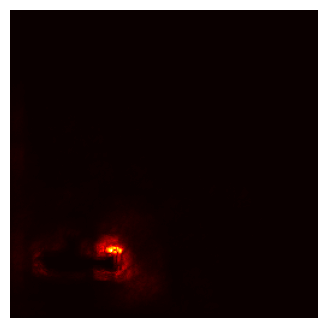

In [13]:
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import tensorflow as tf

# Load your model
# model_ready = load_model(r'CNN_ResNet_classic_data.h5')
# model_ready =  keras.models.load_model(r'CNN_ResNet_classic_data.h5')
# model_ready =  keras.models.load_model(r'CNN_ResNet_classic_data.h5')
# model_ready =  keras.models.load_model(r'CNN_ResNet_mask_data.h5')
model_ready = keras.models.load_model(r'Baseline_run_on_mask_data.h5')
# Prepare the image
path_data_to_test = r"C:\Users\bapti\Downloads\Mask_data_ready\Test\LEFT\Trout\IMG_7946_processed.jpg"

#For UBUNTU:
path_data_to_test = Path('/mnt/c/Users/bapti/Downloads/Mask_data_ready/Test/LEFT/Trout/IMG_7946_processed.jpg')
# path_data_to_test = Path('/mnt/c/Users/bapti/Downloads/ML_Project/Data_ready/Test/LEFT/Trout/IMG_7946.jpg')
print(model_ready.input_shape)

img = load_img(path_data_to_test, target_size=(256, 256)) # CHANGE THE RESIZE FOR THE CORECT MODEL + HAVE THE RIGHT PREPROCESSING FUNCTION
x = img_to_array(img)  # Convert to numpy array
x = x.reshape((1,) + x.shape)  # Add batch dimension
x = x / 255.0  # Normalize image data if your model expects normalized inputs

# Convert the last activation layer to linear
model_ready.layers[-1].activation = None  # For TensorFlow 2.x compatibility

# Define the class index you want to visualize
class_index = 0  # Change this to match your target class index
score = CategoricalScore([class_index])

# Create Saliency object
saliency = Saliency(model_ready, clone=False)

# Generate saliency map
saliency_map = saliency(score, x, smooth_samples=20, smooth_noise=0.2)
saliency_map = normalize(saliency_map)  # Normalize values for visualization

# Plot saliency map
plt.figure(figsize=(5, 4))
plt.imshow(saliency_map[0], cmap='hot')
plt.axis('off')
plt.show()


In [14]:


from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# # ALREADY LOADED ABOVE 
# #model_ready =  keras.models.load_model(r'CNN_ResNet_classic_data.h5')
# # model_ready =  keras.models.load_model(r'CNN_ResNet_classic_data.h5')
# # model_ready =  keras.models.load_model(r'CNN_ResNet_mask_data.h5')
# model_ready = keras.models.load_model(r'Baseline_run_on_mask_data.h5')
# model_ready = keras.models.load_model(r'Augmented_run_on_mask_data.h5')
# model_ready = keras.models.load_model(r'Augmented_run_on_classic_data.h5')
# # print("model_ready.summary()")
# # print(model_ready.summary())
# # print("model_ready.summary()")
# # prediction = model_ready.predict(x)
# # print("Predicted class probabilities:", prediction)

# Prepare the image
path_data_to_test = r"C:\Users\bapti\Downloads\Mask_data_ready\Test\LEFT\Trout\IMG_7946_processed.jpg"

#For UBUNTU:
#Left mask data
# path_data_to_test = Path('/mnt/c/Users/bapti/Downloads/Mask_data_ready/Test/LEFT/Trout/IMG_7946_processed.jpg')
# #Right mask data
# path_data_to_test = Path('/mnt/c/Users/bapti/Downloads/Mask_data_ready/Test/RIGHT/Trout/IMG_8380_processed.jpg')
# #path_data_to_test = Path('/mnt/c/Users/bapti/Downloads/ML_Project/Data_ready/Test/LEFT/Trout/IMG_7946.jpg')
# #Left classic data
path_data_to_test = Path('/mnt/c/Users/bapti/Downloads/ML_Project/Data_ready/Test/LEFT/Trout/IMG_7946.jpg')
# #Right classic data
# path_data_to_test = Path('/mnt/c/Users/bapti/Downloads/ML_Project/Data_ready/Test/RIGHT/Trout/IMG_8380.jpg')

img = load_img(path_data_to_test, target_size=(224, 224))
x = img_to_array(img)  # Convert to numpy array
x = x.reshape((1,) + x.shape)  # Add batch dimension
x = x / 255.0  # Normalize image data if your model expects normalized inputs

# Convert the last activation layer to linear
model_ready.layers[-1].activation = None  # For TensorFlow 2.x compatibility

# Define the class index you want to visualize
class_index = 0  # Change this to match your target class index
score = CategoricalScore([class_index])

# Create Saliency object
saliency = Saliency(model_ready, clone=False)

# Generate saliency map
saliency_map = saliency(score, x, smooth_samples=20, smooth_noise=0.2)
saliency_map = normalize(saliency_map)  # Normalize values for visualization

# Slightly amplify the saliency map
saliency_map_rescaled = (saliency_map[0] - saliency_map[0].min()) / (saliency_map[0].max() - saliency_map[0].min())
saliency_map_rescaled = np.clip(saliency_map_rescaled * 1.5, 0, 1)  # Moderate amplification
saliency_map_rescaled = np.uint8(255 * saliency_map_rescaled)  # Scale to 0-255

# Create a red-highlighted colormap
saliency_colormap = np.zeros((*saliency_map_rescaled.shape, 3), dtype=np.uint8)
saliency_colormap[..., 0] = saliency_map_rescaled  # Intensified red channel
saliency_colormap[..., 1] = 0  # No green
saliency_colormap[..., 2] = 0  # No blue

# Original image preparation
original_image = np.uint8(x[0] * 255)  # Rescale original image to 0-255

# Blend original image and saliency map (red highlight)
alpha = 0.5  # Lower alpha for subtle emphasis on saliency
blended = np.uint8(original_image * (1 - alpha) + saliency_colormap * alpha)

# Plot original, saliency map, and overlay
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_image.astype('uint8'))
plt.axis('off')

# Saliency map
plt.subplot(1, 3, 2)
plt.title('Saliency Map')
plt.imshow(saliency_map[0], cmap='hot')
plt.axis('off')

# Overlay
plt.subplot(1, 3, 3)
plt.title('Overlay with Saliency')
plt.imshow(blended)
plt.axis('off')

plt.tight_layout()
plt.show()
# print("Saliency Map Values:", saliency_map)
# print("Saliency Map Min:", saliency_map.min())
# print("Saliency Map Max:", saliency_map.max())
# prediction = model_ready.predict(x)
# print("Prediction:", prediction)
# print("Input shape:", x.shape)
# print("Model input shape:", model_ready.input_shape)
# x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)  # Ensure input is a tf.Tensor
# with tf.GradientTape() as tape:
#     tape.watch(x_tensor)  # Watch the input image
#     predictions = model_ready(x_tensor)  # Forward pass
#     target_class_score = predictions[:, 0]  # Score for the target class (class_index = 0)

# grads = tape.gradient(target_class_score, x_tensor)  # Compute gradients w.r.t. input
# print("Gradients shape:", grads.shape)
# print("Gradients min:", tf.reduce_min(grads).numpy())
# print("Gradients max:", tf.reduce_max(grads).numpy())




ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 25600, but received input with shape (1, 20736)[0m

Arguments received by Sequential.call():
  • inputs=['tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)']
  • training=False
  • mask=['None']

In [ ]:
# # Load your model
# #model_ready =  keras.models.load_model(r'CNN_ResNet_classic_data.h5')
# # model_ready =  keras.models.load_model(r'CNN_ResNet_classic_data.h5')
# model_ready =  keras.models.load_model(r'CNN_ResNet_mask_data.h5')
# # model_ready = keras.models.load_model(r'Baseline_run_on_mask_data.h5')
# # model_ready = keras.models.load_model(r'Augmented_run_on_mask_data.h5')
# # model_ready = keras.models.load_model(r'Augmented_run_on_classic_data.h5')
# # print("model_ready.summary()")
# # print(model_ready.summary())
# # print("model_ready.summary()")
# # prediction = model_ready.predict(x)
# # print("Predicted class probabilities:", prediction)

# import tensorflow as tf
# import numpy as np

# # Prepare arrays to hold the images and labels from the test set
# test_images = []
# test_labels = []

# # Collect images and labels from the test set
# for image_batch, label_batch in test_set:
#     # Resize images to (224, 224)
#     resized_images = tf.image.resize(image_batch, (224, 224))
#     test_images.append(resized_images.numpy())  # Convert the batch to numpy array
#     test_labels.append(label_batch.numpy())  # Convert the batch to numpy array


# # Flatten the list of images and labels into a single array
# test_images = np.concatenate(test_images, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)

# # Normalize the images to range [0, 1] (assuming the model expects normalized inputs)
# test_images = test_images / 255.0

# # Predict the labels using the trained model
# predictions = model_ready.predict(test_images)

# # Correct predictions: compare the predicted class with the true integer labels
# correct_preds = np.argmax(predictions, axis=1) == test_labels

# # For best prediction: Highest confidence for the correct predictions
# best_confidence = np.max(predictions[correct_preds], axis=1)  # Maximum confidence for correct predictions
# best_idx = np.argmax(best_confidence)  # Index of the highest confidence for a correct prediction

# # For worst prediction: Lowest confidence for the wrong predictions
# wrong_preds = ~correct_preds

# # Ensure there are wrong predictions before trying to find the worst one
# if np.any(wrong_preds):  # Check if there are any wrong predictions
#     worst_confidence = np.max(predictions[wrong_preds], axis=1)  # Maximum confidence for wrong predictions
#     worst_idx = np.argmin(worst_confidence)  # Index of the lowest confidence for a wrong prediction
#     # Get the worst image and label
#     worst_image = test_images[worst_idx]  # Image for worst prediction
#     worst_label = test_labels[worst_idx]
# else:
#     # Handle the case where there are no wrong predictions
#     print("No wrong predictions found.")
#     worst_image = None
#     worst_label = None

# # Get the best image and label
# best_image = test_images[best_idx]  # Image for best prediction
# best_label = test_labels[best_idx]

# # Proceed with the rest of the code for saliency visualization...



2024-11-30 13:55:10.321647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 589ms/step
No wrong predictions found.


In [ ]:
#Don't forget to run preprocessed data before (so that have the right format)
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Define a function to plot the saliency maps
def plot_saliency_map(image, model, class_index, smooth_samples=20, smooth_noise=0.2):
    # Prepare image for saliency map calculation
    x = image.reshape((1,) + image.shape)  # Add batch dimension
    x = x / 255.0  # Normalize if your model expects normalized inputs
    
    # Convert the last activation layer to linear
    model.layers[-1].activation = None  # For TensorFlow 2.x compatibility
    
    # Define the score (class index)
    score = CategoricalScore([class_index])
    
    # Create the Saliency object
    saliency = Saliency(model, clone=False)
    
    # Generate saliency map
    saliency_map = saliency(score, x, smooth_samples=smooth_samples, smooth_noise=smooth_noise)
    saliency_map = normalize(saliency_map)  # Normalize for visualization
    
    # Slightly amplify the saliency map
    saliency_map_rescaled = (saliency_map[0] - saliency_map[0].min()) / (saliency_map[0].max() - saliency_map[0].min())
    saliency_map_rescaled = np.clip(saliency_map_rescaled * 1.5, 0, 1)  # Moderate amplification
    saliency_map_rescaled = np.uint8(255 * saliency_map_rescaled)  # Scale to 0-255
    
    # Create a red-highlighted colormap
    saliency_colormap = np.zeros((*saliency_map_rescaled.shape, 3), dtype=np.uint8)
    saliency_colormap[..., 0] = saliency_map_rescaled  # Intensified red channel
    saliency_colormap[..., 1] = 0  # No green
    saliency_colormap[..., 2] = 0  # No blue
    
    # Original image preparation
    original_image = np.uint8(x[0] * 255)  # Rescale original image to 0-255
    
    # Blend original image and saliency map (red highlight)
    alpha = 0.5  # Lower alpha for subtle emphasis on saliency
    blended = np.uint8(original_image * (1 - alpha) + saliency_colormap * alpha)
    
    # Plot original, saliency map, and overlay
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_image.astype('uint8'))
    plt.axis('off')
    
    # Saliency map
    plt.subplot(1, 3, 2)
    plt.title('Saliency Map')
    plt.imshow(saliency_map[0], cmap='hot')
    plt.axis('off')
    
    # Overlay
    plt.subplot(1, 3, 3)
    plt.title('Overlay with Saliency')
    plt.imshow(blended)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load the trained model
model_ready = keras.models.load_model(r'CNN_ResNet_mask_data.h5')

# Prepare the test images and labels (this part should be the same as before)
test_images = []
test_labels = []
for image_batch, label_batch in test_set:
    resized_images = tf.image.resize(image_batch, (224, 224))
    test_images.append(resized_images.numpy())
    test_labels.append(label_batch.numpy())

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)
test_images = test_images / 255.0

# Predict the labels using the trained model
predictions = model_ready.predict(test_images)

# Correct predictions: compare the predicted class with the true integer labels
correct_preds = np.argmax(predictions, axis=1) == test_labels

# Best prediction: Highest confidence for the correct predictions
best_confidence = np.max(predictions[correct_preds], axis=1)
best_idx = np.argmax(best_confidence)

# Worst prediction: Lowest confidence for the wrong predictions
wrong_preds = ~correct_preds
if np.any(wrong_preds):
    worst_confidence = np.max(predictions[wrong_preds], axis=1)
    worst_idx = np.argmin(worst_confidence)
else:
    print("No wrong predictions found.")
    worst_image = None
    worst_label = None
    worst_idx = None

# Get the best and worst images and labels
best_image = test_images[best_idx]
best_label = test_labels[best_idx]

if worst_idx is not None:
    worst_image = test_images[worst_idx]
    worst_label = test_labels[worst_idx]

    # Plot saliency map for the worst prediction
    print(f"Plotting saliency map for worst prediction (Index: {worst_idx}, Label: {worst_label})")
    plot_saliency_map(worst_image, model_ready, worst_label)

# Plot saliency map for the best prediction
print(f"Plotting saliency map for best prediction (Index: {best_idx}, Label: {best_label})")
plot_saliency_map(best_image, model_ready, best_label)


2024-12-01 10:29:05.203518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/26 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step